In [1]:
import tensorflow as tf
import os
import numpy as np
from scipy import misc
import sys
from random import shuffle
from random import uniform
import zipfile
from collections import OrderedDict
import glob
import time
from PIL import Image
from moviepy.editor import VideoFileClip
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
gt_train_path = '/data2/cityscapes_dataset/gtFine/train'
imgs_train_path = '/data2/cityscapes_dataset/leftImg8bit/train'
gt_val_path = '/data2/cityscapes_dataset/gtFine/val'
imgs_val_path = '/data2/cityscapes_dataset/leftImg8bit/val'
gt_test_path = '/data2/cityscapes_dataset/gtFine/test'
imgs_test_path = '/data2/cityscapes_dataset/leftImg8bit/test'

In [3]:
# Get training data filenames
def get_files(imgs_dir, gt_dir):
    
    cities = os.listdir(imgs_dir)
    gt = []
    imgs = []
    for city in cities:
        new_gt_path = os.path.join(gt_dir, city)
        new_imgs_path = os.path.join(imgs_dir, city)
        gt += glob.glob(os.path.join(new_gt_path, "*labelIds.png"))
        imgs += glob.glob(os.path.join(new_imgs_path, "*.png"))
    imgs.sort()
    gt.sort()
    return imgs, gt

In [4]:
train_imgs, train_gt = get_files(imgs_train_path, gt_train_path)
val_imgs, val_gt = get_files(imgs_val_path, gt_val_path)
test_imgs, test_gt = get_files(imgs_test_path, gt_test_path)

In [5]:
# training: use only the first 700 images
#train_imgs = train_imgs[:700]
#train_gt = train_gt[:700]

In [5]:
len(train_imgs), len(train_gt)

(2975, 2975)

In [6]:
type(train_imgs), len(train_imgs), train_imgs[0]

(list,
 2975,
 '/data2/cityscapes_dataset/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png')

In [7]:
# random image for unit tests
random_im_path = '/data2/cityscapes_dataset/leftImg8bit/train/jena/jena_000118_000019_leftImg8bit.png'
random_gt_path = '/data2/cityscapes_dataset/gtFine/train/jena/jena_000118_000019_gtFine_color.png'
random_instance_path = '/data2/cityscapes_dataset/gtFine/train/jena/jena_000118_000019_gtFine_instanceIds.png'
random_label_path = '/data2/cityscapes_dataset/gtFine/train/jena/jena_000118_000019_gtFine_labelIds.png'

In [8]:
# downloaded into current directory from ftp://mi.eng.cam.ac.uk/pub/mttt2/models/vgg16.npy
vgg_path = 'vgg16.npy'
# From the VGG paper
vgg_means = [103.939, 116.779, 123.68]

# Utility Functions

In [9]:
def plot_image(image_path=None, img=None, from_path=True):
    if (from_path == True):
        img = misc.imread(image_path)
    if len(img.shape) == 4:
        img = np.squeeze(img)
    if img.dtype != np.uint8:
        img = img.astype(np.uint8)
    plt.imshow(img)
    plt.show()

In [10]:
# num_classes = 20, 19 objects classes plus one background glass

def prepare_ground_truth(img):
    
    # Five classes: road, side_walk, pedestrian, vehicles, others
    NUM_CLASSES = 20
    new_image = np.zeros((img.shape[0], img.shape[1], NUM_CLASSES))
    
    # (original_id)
    # road
    road_mask = img == 7
    # sidewalk 
    sidewalk_mask = img == 8
    
    building_mask = img == 11
    wall_mask = img == 12
    fence_mask = img == 13
    pole_mask = img == 17
    traffic_light_mask = img == 19
    traffic_sign_mask = img == 20
    vegetation_mask = img == 21
    terrain_mask = img == 22
    sky_mask = img == 23
    person_mask = img == 24
    rider_mask = img == 25
    car_mask = img == 26
    truck_mask = img == 27
    bus_mask = img == 28
    train_mask = img == 31
    motorcycle_mask = img == 32
    bicycle_mask = img == 33
    
    # everything else
    else_mask = np.logical_not(np.logical_or.reduce((road_mask, sidewalk_mask, building_mask, wall_mask,
                                                     fence_mask, pole_mask, traffic_light_mask, traffic_sign_mask,
                                                     vegetation_mask, terrain_mask, sky_mask, person_mask,
                                                     rider_mask, car_mask, truck_mask, bus_mask,
                                                     train_mask, motorcycle_mask, bicycle_mask)))


    new_image[:,:,0] = road_mask
    new_image[:,:,1] = sidewalk_mask
    new_image[:,:,2] = building_mask
    new_image[:,:,3] = wall_mask
    new_image[:,:,4] = fence_mask
    new_image[:,:,5] = pole_mask
    new_image[:,:,6] = traffic_light_mask
    new_image[:,:,7] = traffic_sign_mask
    new_image[:,:,8] = vegetation_mask
    new_image[:,:,9] = terrain_mask
    new_image[:,:,10] = sky_mask
    new_image[:,:,11] = person_mask
    new_image[:,:,12] = rider_mask
    new_image[:,:,13] = car_mask
    new_image[:,:,14] = truck_mask
    new_image[:,:,15] = bus_mask
    new_image[:,:,16] = train_mask
    new_image[:,:,17] = motorcycle_mask
    new_image[:,:,18] = bicycle_mask
    new_image[:,:,19] = else_mask
    
    return new_image.astype(np.float32)


In [11]:
tmp = shape_im = misc.imread(random_im_path)

In [12]:
tmp.shape

(1024, 2048, 3)

In [13]:
def get_data(batch_size=1, num_classes=20, mode='train', imgs=train_imgs, gt=train_gt, im_size=500, no_crop=False):
    
    # Expects sorted lists of training images and ground truth as
    # 'data' and 'labels'
    if (mode == 'val'):
        imgs = val_imgs
        gt = val_gt
    elif (mode == 'test'):
        imgs = test_imgs
        gt = test_gt
    
    # get shape from any image
    shape_im = misc.imread(random_im_path)
    
    # Shuffle dataset
    if mode=='train':
        combined = list(zip(imgs, gt))
        shuffle(combined)
        imgs[:], gt[:] = zip(*combined)
    
    while(True):
        for i in range(0,len(imgs),batch_size):
            if (no_crop):
                images = np.empty((batch_size, shape_im.shape[0], shape_im.shape[1], shape_im.shape[2]))
                labels = np.empty((batch_size, shape_im.shape[0], shape_im.shape[1], num_classes))
                for j, img in enumerate(imgs[i:i+batch_size]):
                    train_im = misc.imread(img).astype(np.float32)
                    images[j,:,:,:] = train_im
                    gt_im = misc.imread(gt[i+j])
                    labels[j,:,:,:] = prepare_ground_truth(gt_im)                   
            else:
                images = np.empty((batch_size, im_size, im_size, shape_im.shape[2]))
                labels = np.empty((batch_size, im_size, im_size, num_classes))
                for j, img in enumerate(imgs[i:i+batch_size]):
                    # Crop the size we want from a random spot in the image (as a form of
                    # minor data augmentation)
                    new_start_row = np.random.randint(0, shape_im.shape[0] - im_size)
                    new_start_col = np.random.randint(0, shape_im.shape[1] - im_size)
                    train_im = misc.imread(img).astype(np.float32)

                    train_im = train_im[new_start_row:new_start_row+im_size, new_start_col:new_start_col+im_size]
                    images[j,:,:,:] = train_im

                    gt_im = misc.imread(gt[i+j])
                    gt_im = gt_im[new_start_row:new_start_row+im_size, new_start_col:new_start_col+im_size]
                    labels[j,:,:,:] = prepare_ground_truth(gt_im)
            
            yield(images,labels)
            

In [14]:
train_gen_data = get_data(batch_size=1, num_classes=20, mode='train', imgs=train_imgs, gt=train_gt, im_size=500)

In [15]:
train_images, train_labels =  next(train_gen_data)

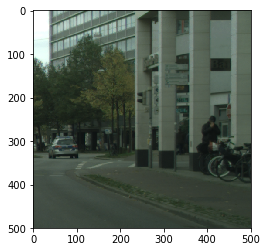

In [16]:
plot_image(img=train_images, from_path=False)

In [17]:
# visualize_prediction for cityscape data
def visualize_prediction(original_image, prediction):
    
    original_image = np.squeeze(original_image).astype(np.uint8)
    new_image = np.copy(original_image)
    prediction = np.squeeze(prediction)
    mask = np.argmax(prediction, axis=2)
    # road = green
    # new_image[mask[:,:]==0, :] = [0,255,0]
    # sidewalk = blue
    #new_image[mask[:,:]==1, :] = [0,0,255]
    # pedestrians = yellow
    #new_image[mask[:,:]==2, :] = [255,255,0]
    # vehicles = red
    #new_image[mask[:,:]==3, :] = [255,0,0]
    # else is left the same
    
    new_image[mask[:,:]==0, :] = [128, 64, 128]
    new_image[mask[:,:]==1, :] = [244, 35, 232]
    new_image[mask[:,:]==2, :] = [70, 70, 70]
    new_image[mask[:,:]==3, :] = [102, 102, 156]
    new_image[mask[:,:]==4, :] = [190, 153, 153]
    new_image[mask[:,:]==5, :] = [153, 153, 153]
    new_image[mask[:,:]==6, :] = [250, 170, 30]
    new_image[mask[:,:]==7, :] = [220, 220,  0]
    new_image[mask[:,:]==8, :] = [107, 142, 35]
    new_image[mask[:,:]==9, :] = [128, 64, 128]
    new_image[mask[:,:]==10, :] = [152, 251, 152]
    new_image[mask[:,:]==11, :] = [220, 20, 60]
    new_image[mask[:,:]==12, :] = [255,  0,  0]
    new_image[mask[:,:]==13, :] = [0, 0, 142]
    new_image[mask[:,:]==14, :] = [0, 0, 70]
    new_image[mask[:,:]==15, :] = [0, 60, 100]
    new_image[mask[:,:]==16, :] = [0, 80, 100]
    new_image[mask[:,:]==17, :] = [0, 0, 230]
    new_image[mask[:,:]==18, :] = [119, 11, 32]
    new_image[mask[:,:]==19, :] = [128, 64, 128]
    
    new_image = Image.blend(Image.fromarray(original_image, mode='RGB').convert('RGBA'),
                            Image.fromarray(new_image, mode='RGB').convert('RGBA'),
                            alpha=0.5)
    
    plt.imshow(new_image, interpolation='nearest')
    plt.show()

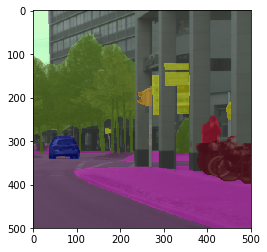

In [18]:
visualize_prediction(train_images, train_labels)

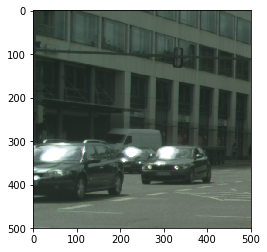

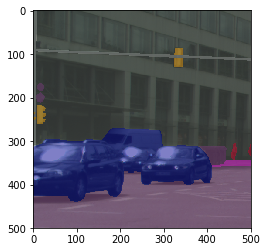

In [19]:
train_gen_data = get_data(batch_size=1, num_classes=20, mode='train', im_size=500)
train_images, train_labels = next(train_gen_data)
plot_image(img=train_images, from_path=False)
visualize_prediction(train_images, train_labels)

In [20]:
train_gen_data = get_data(batch_size=1, num_classes=20, mode='train', imgs=train_imgs, gt=train_gt, im_size=500)

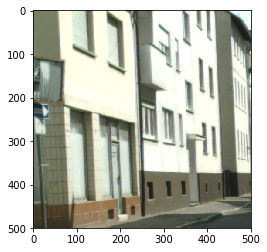

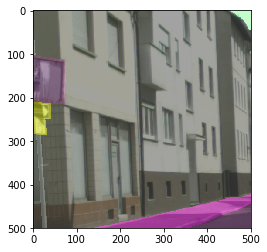

In [21]:
val_gen_data = get_data(batch_size=1, num_classes=20, mode='val', im_size=500)
val_images, val_labels = next(val_gen_data)
plot_image(img=val_images, from_path=False)
visualize_prediction(val_images, val_labels)

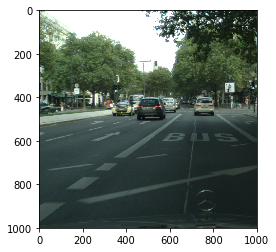

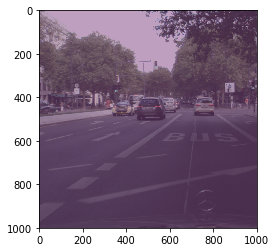

In [22]:
test_gen_data = get_data(batch_size=1, num_classes=20, mode='test', im_size=1000)
test_images, test_labels = next(test_gen_data)
plot_image(img=test_images, from_path=False)
visualize_prediction(test_images, test_labels)

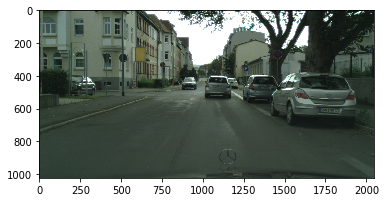

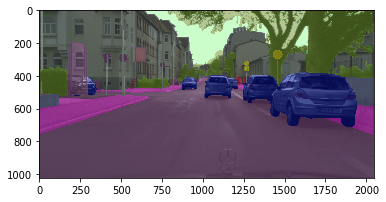

In [23]:
# Check the visualization with ground truth
rand_gt = misc.imread(random_label_path)
rand_im = misc.imread(random_im_path)
plot_image(img=rand_im, from_path=False)
prepped = prepare_ground_truth(rand_gt)
visualize_prediction(rand_im, prepped)

# Model-Building Functions

In [24]:
def vgg_conv(layer_input, vgg_dict, bn, name):
    
    with tf.variable_scope(name):
        
        # Get the conv filter
        init = tf.constant_initializer(value=vgg_dict[name][0], dtype=tf.float32)
        shape = vgg_dict[name][0].shape
        filt = tf.get_variable(name="filter", initializer=init, shape=shape)
        # Get the conv bias
        init = tf.constant_initializer(value=vgg_dict[name][1], dtype=tf.float32)
        shape = vgg_dict[name][1].shape
        bias = tf.get_variable(name="biases", initializer=init, shape=shape)
        # Construct conv layer
        conv = tf.nn.conv2d(layer_input, filt, [1, 1, 1, 1], padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, bias), name=name)
        return tf.contrib.layers.batch_norm(relu, center=True, scale=True, is_training=True)

In [25]:
# Helper function for deconvolutional layers
# Note that this function is different than the Unet deconv functions
def deconv2d(layer_input, output_shape, input_fsize, output_fsize, filter_size, stride, bn, name):
    # shape = [filter_height, filter_width, out_channels, in_channels]
    w = tf.get_variable("filter_" + name, shape=[filter_size, filter_size, output_fsize, input_fsize], 
                        initializer=tf.contrib.layers.xavier_initializer_conv2d(), 
                        regularizer=tf.contrib.layers.l2_regularizer(.001))
    b = tf.Variable(tf.constant(0.1, shape=[output_fsize]))
    # representing the output shape of the deconvolution op
    # [filter_height, filter_width, out_channels, in_channels]
    new_shape = tf.stack([output_shape[0], output_shape[1], output_shape[2], output_fsize])
    deconv = tf.nn.conv2d_transpose(value=layer_input, filter=w, output_shape=new_shape, strides=[1, stride, stride, 1], padding='SAME')
    layer = tf.nn.elu(tf.add(deconv, b))
    return tf.contrib.layers.batch_norm(layer, center=True, scale=True, is_training=True)

In [26]:
def conv_layer(layer_input, input_fsize, output_fsize, filter_size, bn, name):
    w = tf.get_variable("filter_" + name, shape=[filter_size, filter_size, input_fsize, output_fsize], 
                        initializer=tf.contrib.layers.xavier_initializer_conv2d(), 
                        regularizer=tf.contrib.layers.l2_regularizer(.001))
    # initialize the bias with all 0.1
    b = tf.Variable(tf.constant(0.1, shape=[output_fsize]))
    layer = tf.nn.elu(tf.add(tf.nn.conv2d(layer_input, w, strides=[1, 1, 1, 1], padding='SAME'), b))
    return tf.contrib.layers.batch_norm(layer, center=True, scale=True, is_training=True)


In [27]:
??tf.stack

In [37]:
img_rows=1024
img_cols=2048
channels=3
img_stack=tf.stack([-1,img_rows,img_cols,channels])

In [38]:
type(img_stack)

tensorflow.python.framework.ops.Tensor

# Construct Model

In [30]:
# similiar to def forward_propagation(X, parameters):

def create_FCN_VGG(imgs, vgg_dict, dropout=0.5, channels=3, num_classes=20, filter_size=1, bn=True):
    
    im_rows = tf.shape(imgs)[1]
    im_cols = tf.shape(imgs)[2]
    
    x_image = tf.reshape(imgs, tf.stack([-1,im_rows,im_cols,channels]))
    layer_input = x_image
    # obtain the batchsize using tf.shape(x)[0] during running
    batch_size = tf.shape(x_image)[0]
    
    # VGG pre-processing
    # tf.split(dimension, num_split, input), very good way to separate 3 different channels
    red, green, blue = tf.split(value=x_image, num_or_size_splits=3, axis=3)
    
    # concate them again
    x_image = tf.concat([
        blue - vgg_means[0],
        green - vgg_means[1],
        red - vgg_means[2]], axis=3)
    
    x_image = x_image / 122.5
    
    # Encoder
    # output = vgg_conv(input, conv_weight, bn, name)
    conv1_1 = vgg_conv(x_image, vgg_dict, bn, "conv1_1")
    conv1_2 = vgg_conv(conv1_1, vgg_dict, bn, "conv1_2")
    pool1 = tf.nn.max_pool(conv1_2, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME', name="pool1")
    conv2_1 = vgg_conv(pool1, vgg_dict, bn, "conv2_1")
    conv2_2 = vgg_conv(conv2_1, vgg_dict, bn, "conv2_2")
    pool2 = tf.nn.max_pool(conv2_2, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME', name="pool2")
    conv3_1 = vgg_conv(pool2, vgg_dict, bn, "conv3_1")
    conv3_2 = vgg_conv(conv3_1, vgg_dict, bn, "conv3_2")
    conv3_3 = vgg_conv(conv3_2, vgg_dict, bn, "conv3_3")
    pool3 = tf.nn.max_pool(conv3_3, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME', name="pool3")
    conv4_1 = vgg_conv(pool3, vgg_dict, bn, "conv4_1")
    conv4_2 = vgg_conv(conv4_1, vgg_dict, bn, "conv4_2")
    conv4_3 = vgg_conv(conv4_2, vgg_dict, bn, "conv4_3")
    pool4 = tf.nn.max_pool(conv4_3, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME', name="pool4")
    conv5_1 = vgg_conv(pool4, vgg_dict, bn, "conv5_1")
    conv5_2 = vgg_conv(conv5_1, vgg_dict, bn, "conv5_2")
    conv5_3 = vgg_conv(conv5_2, vgg_dict, bn, "conv5_3")
    pool5 = tf.nn.max_pool(conv5_3, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME', name="pool5")

    # VGG depth at the fifth layer (comes from imported weights so
    # it will be constant no matter the size of input image)
    features = 512
        
    # Decoder
    # Combo layer 1
    # conv_layer(layer_input, input_fsize, output_fsize, filter_size, bn, name), default filter_size is 1
    d_conv1 = conv_layer(pool5, features, num_classes, filter_size, bn, "decoder_c1")
    # deconv2d(layer_input, output_shape, input_fsize, output_fsize, filter_size, stride, bn, name)
    d_dconv1 = deconv2d(layer_input=d_conv1, output_shape=tf.shape(pool4), input_fsize=num_classes, 
                        output_fsize=num_classes, filter_size=4, stride=2, bn=bn, name="decoder_d1")
    
    d_conv2 = conv_layer(pool4, features, num_classes, filter_size, bn, "decoder_c2")
    
    # Skip connection
    d_sum1 = tf.add(d_dconv1, d_conv2)
    
    # Combo layer 2
    d_dconv2 = deconv2d(layer_input=d_sum1, output_shape=tf.shape(pool3), input_fsize=num_classes, 
                        output_fsize=num_classes, filter_size=4, stride=2, bn=bn, name="decoder_d2")
    # conv_layer(layer_input, input_fsize, output_fsize, filter_size, bn, name), default filter_size is 1
    d_conv3 = conv_layer(pool3, features//2, num_classes, filter_size, bn, "decoder_c3")
    
    # Skip connection
    d_sum2 = tf.add(d_dconv2, d_conv3)
    
    # Combo layer 3
    # deconv2d(layer_input, output_shape, input_fsize, output_fsize, filter_size, stride, bn, name)
    d_dconv3 = deconv2d(layer_input=d_sum2, output_shape=tf.shape(x_image), input_fsize=num_classes, 
                        output_fsize=num_classes, filter_size=16, stride=8, bn=bn, name="decoder_d3")

    output = d_dconv3
        
    return output


In [31]:
tmp_vgg_dict = np.load(vgg_path, encoding='latin1')

In [33]:
type(tmp_vgg_dict), tmp_vgg_dict.shape

(numpy.ndarray, ())

In [36]:
tmp_vgg_dict = tmp_vgg_dict.item()

In [37]:
type(tmp_vgg_dict)

dict

In [38]:
tmp_vgg_dict.keys()

dict_keys(['fc7', 'conv3_3', 'conv5_1', 'conv4_1', 'conv3_2', 'conv2_1', 'conv5_2', 'conv2_2', 'conv5_3', 'conv1_2', 'conv4_2', 'conv3_1', 'fc8', 'conv4_3', 'conv1_1', 'fc6'])

In [41]:
len(tmp_vgg_dict['conv1_1'])

2

In [45]:
tmp_vgg_dict['conv1_2'][0].shape

(3, 3, 64, 64)

In [46]:
tmp_vgg_dict['conv1_2'][1].shape

(64,)

In [69]:
# build the FCN_VGG model
class FCN_VGG:
    
    def __init__(self, channels=3, num_classes=20, output_path='./output'):
        
        # prediction path is to store validation prediction images in if necessary
        self.prediction_path = "./predictions"
        
        # output path for trained model 
        self.output_path = output_path
        
        if not os.path.exists(self.prediction_path):
            os.mkdir(self.prediction_path)
        if not os.path.exists(self.output_path):
            os.mkdir(self.output_path)
        # to be able to rerun the model without overwriting tf variables        
        tf.reset_default_graph()
        
        self.num_classes = num_classes
        
        # load the VGG weights : vgg16.npy
        # npy file is binary file format for numpy array
        self.vgg_dict = np.load(vgg_path, encoding='latin1').item()
        
        # placeholder for input image
        self.x = tf.placeholder("float", shape=[None, None, None, channels], name="x")
        
        # placeholder for label, size extended as image 
        self.y = tf.placeholder("float", shape=[None, None, None, num_classes], name="y")
        
        # dropout prob.
        self.drop_pl = tf.placeholder("float", name="do")
        
        # batch norm
        self.bn = tf.placeholder("bool", name="bn")
        
        # output logit - run forward_propagation, logits score (not-yet prob.)
        # self.x, self.drop_pl are placeholder
        logits = create_FCN_VGG(self.x, self.vgg_dict, dropout=self.drop_pl, channels=channels, num_classes=num_classes)
        self.logits = logits
        
        # convert to prob. using softmax
        self.soft = self.pixel_wise_softmax(logits)
        self.soft = tf.identity(self.soft, name="output")
        self.loss = self.get_loss(logits)
                
        # These two are for validation
        self.correct_pred = tf.equal(tf.argmax(tf.squeeze(self.soft), -1), tf.argmax(tf.squeeze(self.y), -1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))
            
    # A helper function for computing softmax across the channel-dimension
    def pixel_wise_softmax(self, output):
                
        # Softmax across the last dimension (where each channel is a binary image
        # denoting whether the pixel belongs in that category or not -- this allows
        # for more than two classes)
        # e^x
        
        # output is logits
        exponential_map = tf.exp(output)
        # sum-e^x
        sum_exp = tf.reduce_sum(exponential_map, 3, keep_dims=True)
        # duplicate the last summed dimension
        tensor_sum_exp = tf.tile(sum_exp, tf.stack([1, 1, 1, tf.shape(output)[3]]))
        # divide e^x by sum-e^x 
        return tf.div(exponential_map, tensor_sum_exp)
    
    # compute_cost
    def get_loss(self, logits):
        # note: logits are the score, not prob.
        cost = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(labels=self.y, logits=logits))
        
        reg_loss = sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
        
        cost += reg_loss
        
        return cost

    
    def predict(self, model_path, img, gt=None, restore=True):
    
        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            
            sess.run(init)
            # model_path = 'fcn_vgg_city2.ckpt'
            if restore:
                self.restore(sess, os.path.join(self.output_path, model_path))
            
            #if gt != None:
            if isinstance(gt, np.ndarray):
                # when gt is provided, accuracy can be evaluated
                soft, acc = sess.run([self.soft, self.accuracy], feed_dict={self.x: img, self.y: gt,
                                                                            self.drop_pl: 1.0, self.bn: False})
                return soft, acc
            else:
                # no accuracy evaluated
                soft = sess.run(self.soft, feed_dict={self.x: img, self.drop_pl: 1.0, self.bn: False})
                return soft
    
    def save(self, sess, model_path):
        # save the variabless in sess (including weights and variables, but no graph structures are included) into model_path ('fcn_vgg_city2.ckpt')
        saver = tf.train.Saver()
        save_path = saver.save(sess, model_path)
        return save_path
    
    def restore(self, sess, model_path):
        
        saver = tf.train.Saver()
        saver.restore(sess, model_path)
    
    def train(self, data_generator, dropout=0.5, training_iters=10, learning_rate=0.0001, epochs=10, display_step=10, restore=False, model_path=None):
        # training_iters: e.g. 12000, one iter. corresponds to one minibatch
        # epochs: full sweep through the dataset
        # output_path = './output', model_path = 'fcn_vgg_city2.ckpt'
        # then model_path = './output/fcn_vgg_city2.ckpt'
        model_path = os.path.join(self.output_path, model_path) # used for loading trained model
                
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss)
        
        init = tf.global_variables_initializer()
        
        with tf.Session() as sess:
            
            print("Session begun")
            
            sess.run(init)
        
            if restore:
                self.restore(sess, model_path)

            for epoch in range(epochs):
                
                print("Starting new epoch")
                
                total_loss = 0.0
                display_loss = 0.0
                display_acc = 0.0
                best_acc = .93
                for step in range((epoch*training_iters), ((epoch+1)*training_iters)):
                    # use next() to iterate through x_batch and y_batch
                    x_batch, y_batch = next(data_generator)
                    
                    _, loss, acc, logits = sess.run((self.optimizer, self.loss, self.accuracy, self.logits),
                                                    feed_dict={self.x: x_batch,
                                                              self.y: y_batch,
                                                              self.drop_pl: dropout,
                                                              self.bn: True})
                    # this loss and acc correspond to one minibatch
                    display_loss += loss
                    display_acc += acc
                    
                    if ((step+1) % display_step == 0):
                        print("At iteration {} loss equals {} and accuracy equals {}".format(step+1, display_loss/(display_step), display_acc/(display_step)))
                        
                        if ((display_acc/(display_step)) > best_acc):
                            save_path = self.save(sess, os.path.join(self.output_path, model_path))
                            best_acc = display_acc/display_step
                            print("model saved")
                        total_loss += display_loss
                        display_loss = 0.0
                        display_acc = 0.0
                        
                                                                    
                print("###############################")
                print("Epoch", epoch + 1, "average loss =", total_loss/training_iters)
                print("###############################")
                total_loss = 0                
                
            #save_path = self.save(sess, os.path.join(self.output_path, model_path))
            # already model_path = os.path.join(self.output_path, model_path)
            save_path = self.save(sess, os.path.join(model_path))
        
        return save_path

# Train Model

In [70]:
tf.reset_default_graph()

In [71]:
my_fcn = FCN_VGG()

In [51]:
# Not enough RAM for large batch given
# the size of these images
batch_generator = get_data(mode='train', batch_size=1, im_size=500)
#batch_generator = get_data(mode='val', batch_size=10, im_size=500)
model_path = 'fcn_vgg_city_new170927b.ckpt'

In [52]:
output_path = my_fcn.train(batch_generator, learning_rate=8e-4,
                          training_iters=200, epochs=1, display_step=100,
                          restore=False, model_path=model_path)

Session begun
Starting new epoch
At iteration 100 loss equals 673293.5809375 and accuracy equals 0.35561896273866295
At iteration 200 loss equals 605504.136875 and accuracy equals 0.455889194495976
At iteration 300 loss equals 583490.69625 and accuracy equals 0.45703715403564277
At iteration 400 loss equals 564403.605 and accuracy equals 0.46426159255206584
###############################
Epoch 1 average loss = 606673.004766
###############################


In [32]:
output_path = my_fcn.train(batch_generator, learning_rate=8e-4,
                          training_iters=12000, epochs=1, display_step=100,
                          restore=False, model_path=model_path)

Session begun
Starting new epoch
At iteration 100 loss equals 646882.8434375 and accuracy equals 0.3726232872530818
At iteration 200 loss equals 614592.85625 and accuracy equals 0.4412422697618604
At iteration 300 loss equals 575633.61875 and accuracy equals 0.4802947260439396
At iteration 400 loss equals 559109.5603125 and accuracy equals 0.4782475230097771
At iteration 500 loss equals 533080.526875 and accuracy equals 0.48722075909376145
At iteration 600 loss equals 523279.53625 and accuracy equals 0.4771417971677147
At iteration 700 loss equals 515780.4696875 and accuracy equals 0.49760640278458595
At iteration 800 loss equals 468034.05 and accuracy equals 0.5550274148210883
At iteration 900 loss equals 466231.783125 and accuracy equals 0.5379400070011616
At iteration 1000 loss equals 447798.280625 and accuracy equals 0.5782298888266086
At iteration 1100 loss equals 427143.449375 and accuracy equals 0.5963572365045547
At iteration 1200 loss equals 443837.99234375 and accuracy equals

# Test Model

In [53]:
# the input image will be cropped 1000x1000 patch
val_imgs, val_gt = get_files(imgs_val_path, gt_val_path)
val_batch_generator = get_data(mode='val', batch_size=1, im_size=1000)

In [54]:
val_img, val_gt = next(val_batch_generator)

In [59]:
type(val_img), type(val_gt)

(numpy.ndarray, numpy.ndarray)

In [60]:
val_img.shape, val_gt.shape

((1, 1000, 1000, 3), (1, 1000, 1000, 20))

In [61]:
model_path

'fcn_vgg_city_new170927a.ckpt'

In [62]:
my_fcn.output_path

'./output'

In [68]:
# for gt of val set, we can compute the accuracy
soft, acc = my_fcn.predict(model_path, val_img, gt=val_gt, restore=True)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [42]:
acc

0.72385597

In [43]:
val_img, val_gt = next(val_batch_generator)

In [44]:
soft, acc = my_fcn.predict(model_path, val_img, gt=val_gt, restore=True)
acc

0.79743582

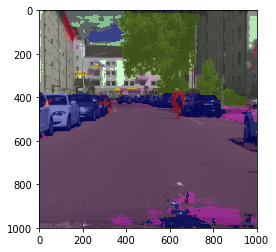

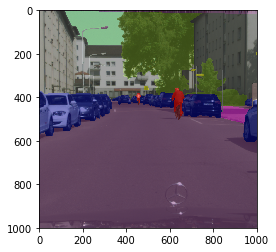

In [45]:
visualize_prediction(val_img, soft)
visualize_prediction(val_img, val_gt)

# Test on all validaton data (500 images)

In [36]:
# the input image will be cropped 1000x1000 patch
val_imgs, val_gt = get_files(imgs_val_path, gt_val_path)
val_batch_generator = get_data(mode='val', batch_size=1, im_size=1000)


In [ ]:
abc
def
ert

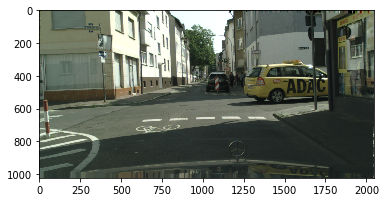

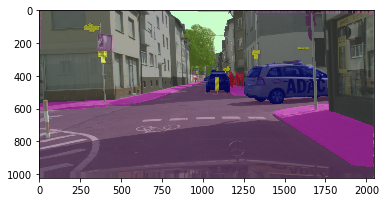

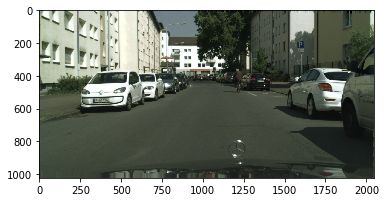

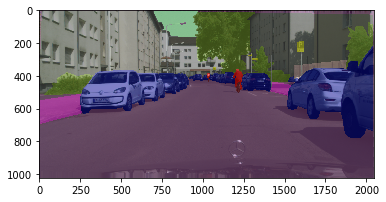

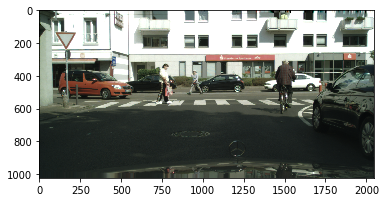

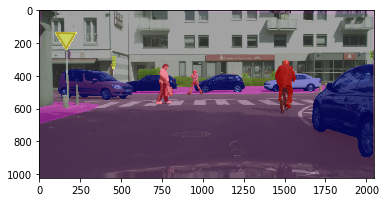

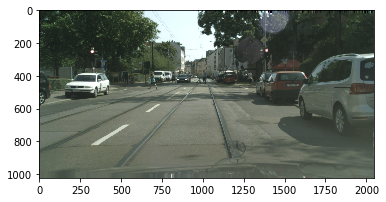

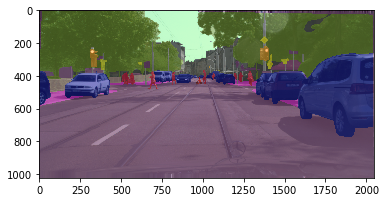

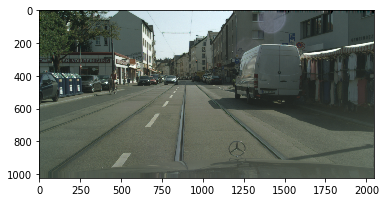

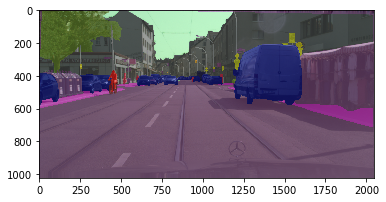

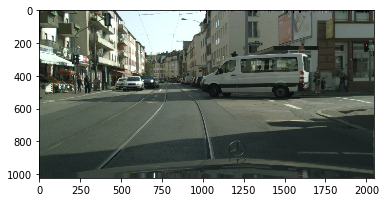

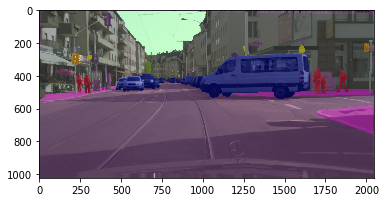

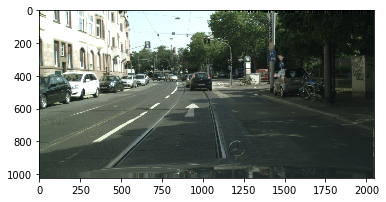

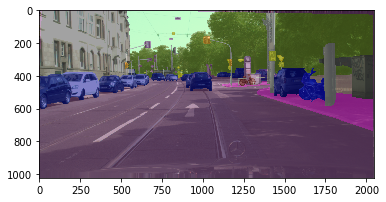

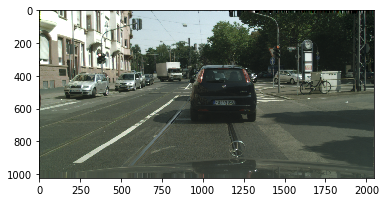

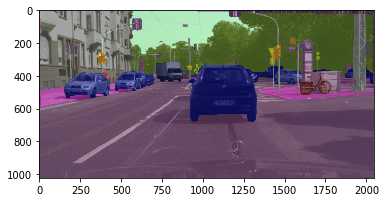

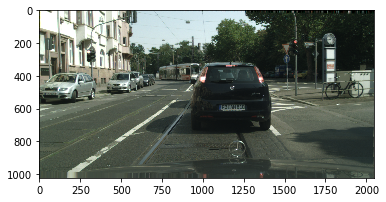

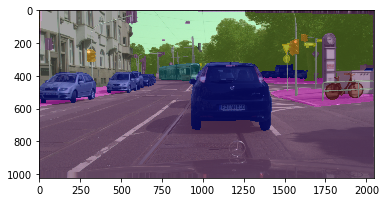

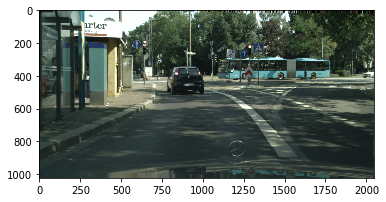

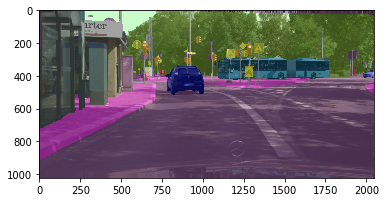

In [46]:
val_imgs, val_gt = get_files(imgs_val_path, gt_val_path)
val_batch_generator = get_data(mode='val', batch_size=1, no_crop=True)
for i in range(10):
    val_img, val_gt = next(val_batch_generator)
    plot_image(img=val_img, from_path=False)
    visualize_prediction(val_img, val_gt)

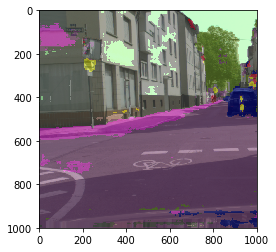

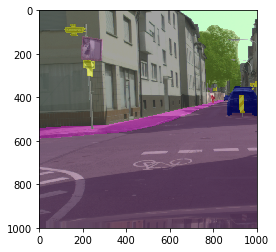

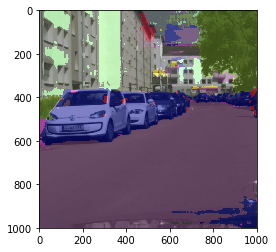

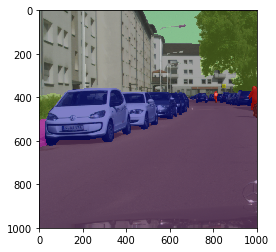

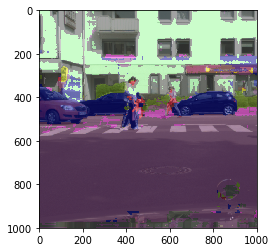

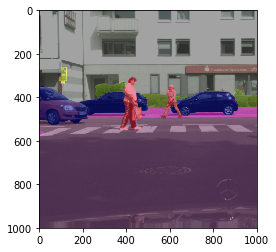

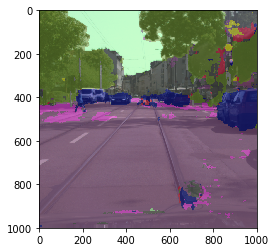

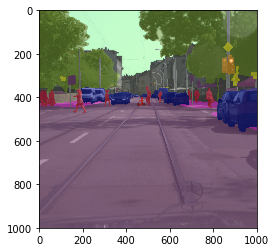

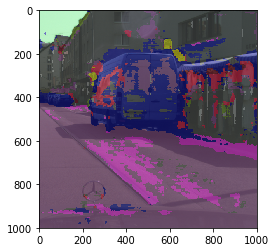

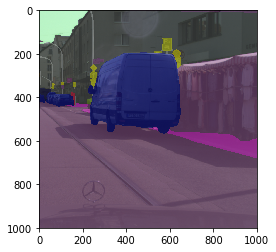

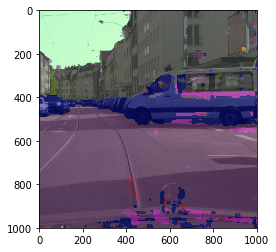

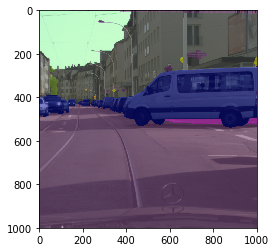

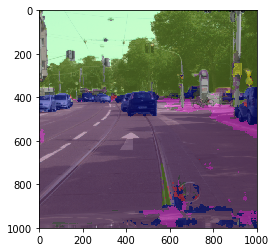

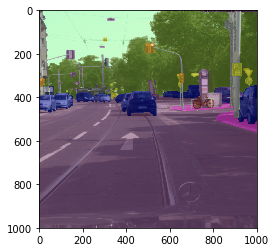

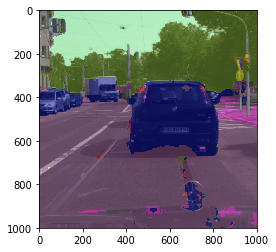

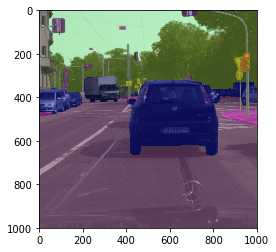

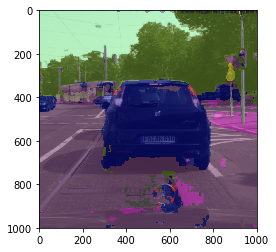

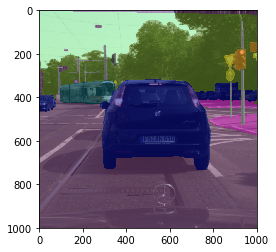

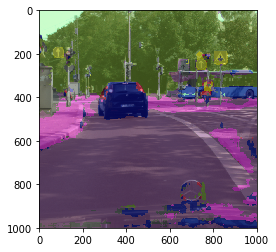

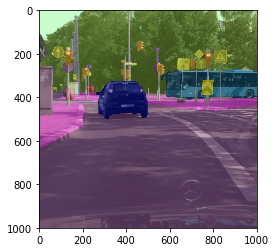

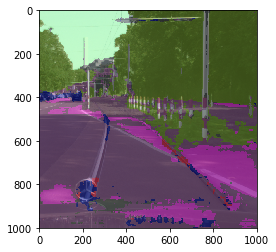

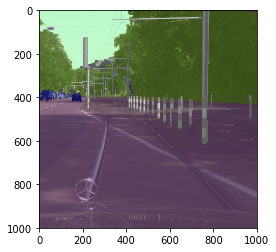

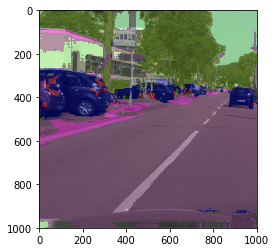

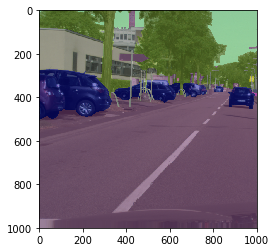

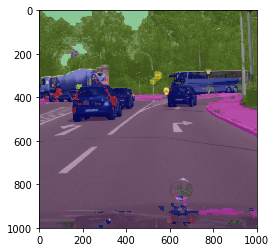

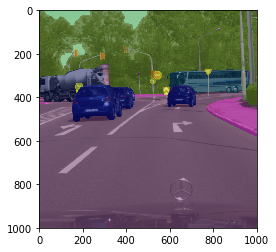

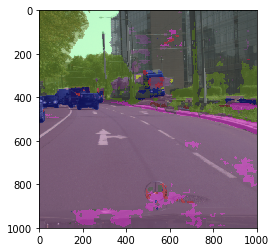

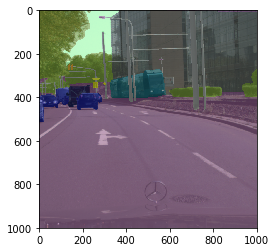

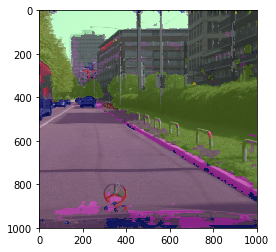

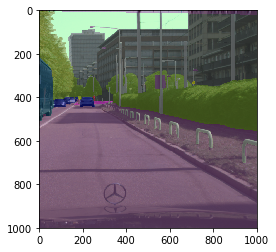

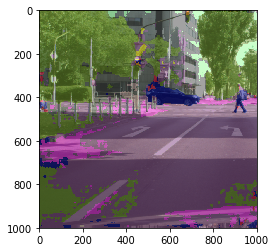

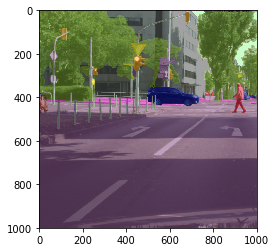

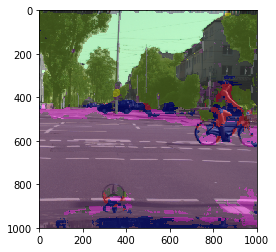

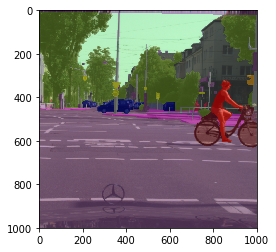

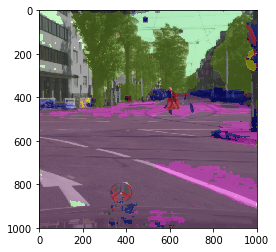

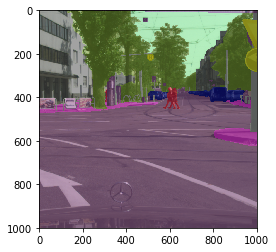

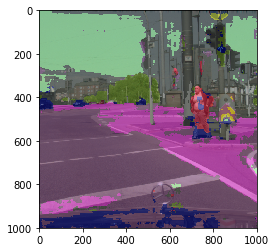

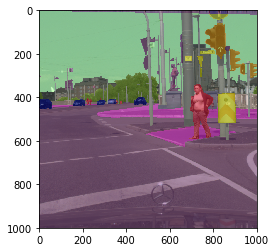

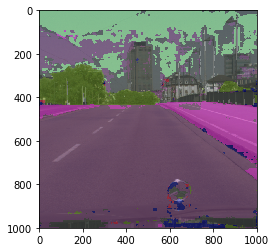

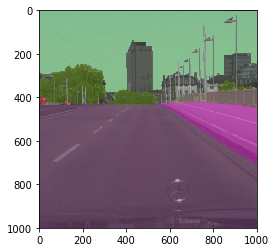

###############################
Average validation set accuracy = 0.762198376656
###############################


In [47]:
total_acc = 0.0
val_size = 20

val_imgs, val_gt = get_files(imgs_val_path, gt_val_path)
val_batch_generator = get_data(mode='val', batch_size=1, im_size=1000)

for i in range(val_size):
    #val_img, val_gt = next(batch_generator)
    val_img, val_gt = next(val_batch_generator)
    results, acc = my_fcn.predict(model_path, val_img, gt=val_gt, restore=True)
    total_acc += acc

    visualize_prediction(val_img, results)
    visualize_prediction(val_img, val_gt)

total_acc /= val_size
print("###############################")
print("Average validation set accuracy =", total_acc)
print("###############################")

In [49]:
import os, argparse

import tensorflow as tf
from tensorflow.python.framework import graph_util

dir = os.path.dirname(os.path.realpath(__file__))

def freeze_graph(model_folder):
    # We retrieve our checkpoint fullpath
    checkpoint = tf.train.get_checkpoint_state(model_folder)
    input_checkpoint = checkpoint.model_checkpoint_path
    
    # We precise the file fullname of our freezed graph
    absolute_model_folder = "/".join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_folder + "/frozen_model.pb"

    # Before exporting our graph, we need to precise what is our output node
    # This is how TF decides what part of the Graph he has to keep and what part it can dump
    # NOTE: this variable is plural, because you can have multiple output nodes
    output_node_names = "Accuracy/predictions"

    # We clear devices to allow TensorFlow to control on which device it will load operations
    clear_devices = True
    
    # We import the meta graph and retrieve a Saver
    saver = tf.train.import_meta_graph(input_checkpoint + '.meta', clear_devices=clear_devices)

    # We retrieve the protobuf graph definition
    graph = tf.get_default_graph()
    input_graph_def = graph.as_graph_def()

    # We start a session and restore the graph weights
    with tf.Session() as sess:
        saver.restore(sess, input_checkpoint)

        # We use a built-in TF helper to export variables to constants
        output_graph_def = graph_util.convert_variables_to_constants(
            sess, # The session is used to retrieve the weights
            input_graph_def, # The graph_def is used to retrieve the nodes 
            output_node_names.split(",") # The output node names are used to select the usefull nodes
        ) 

        # Finally we serialize and dump the output graph to the filesystem
        with tf.gfile.GFile(output_graph, "wb") as f:
            f.write(output_graph_def.SerializeToString())
        print("%d ops in the final graph." % len(output_graph_def.node))

'''
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument("--model_folder", type=str, help="Model folder to export")
    args = parser.parse_args()

    freeze_graph(args.model_folder)
'''

NameError: name '__file__' is not defined

In [ ]:
freeze_graph('./output')

# Freeze model

In [50]:
from tensorflow.python.framework.graph_util import convert_variables_to_constants
from tensorflow.python.tools import inspect_checkpoint

In [51]:
output_path = "./output/"
checkpoint_path = tf.train.latest_checkpoint(output_path)
frozen_name = "frozen_FCN2_170816.pb"

In [52]:
saver = tf.train.import_meta_graph(checkpoint_path + '.meta', import_scope=None)

output_node_names = "output"

with tf.Session() as sess:
    
    # Restore the variable values
    saver.restore(sess, checkpoint_path)
    # Get the graph def from our current graph
    graph_def = tf.get_default_graph().as_graph_def()
    # Turn all variables into constants
    frozen_graph_def = convert_variables_to_constants(sess, graph_def, output_node_names.split(","))
    
    # Save our new graph def
    with tf.gfile.GFile(output_path + frozen_name, "wb") as f:
        f.write(frozen_graph_def.SerializeToString())

INFO:tensorflow:Froze 76 variables.
Converted 76 variables to const ops.


In [53]:
len(frozen_graph_def.node)

968

# Use frozen model

In [54]:
def load_graph(my_path):
    # Load the pb file and parse it to retrieve the 
    # unserialized graph_def
    with tf.gfile.GFile(my_path, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    
    # Now import the graph_def to our default graph.
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(
            graph_def,
            input_map=None,
            return_elements=None,
            # If you put name=None here instead of ''
            # it will relabel all your ops as "import/original_name"
            name='',
            op_dict=None, 
            producer_op_list=None
        )
    # Return the loaded graph
    return graph

In [55]:
graph = load_graph('./output/frozen_FCN2_170816.pb')

In [56]:
x = graph.get_tensor_by_name('x:0')
output = graph.get_tensor_by_name('output:0')

In [57]:
with tf.Session(graph=graph) as sess:

    %time out = sess.run(output, feed_dict={x: val_img})

CPU times: user 416 ms, sys: 36 ms, total: 452 ms
Wall time: 821 ms


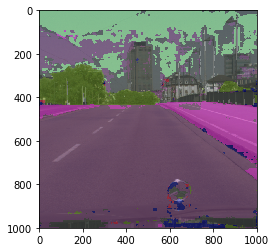

In [58]:
visualize_prediction(val_img, out)

In [59]:
# Optimize_for_inference deletes identity nodes (even if they are the output)
# so I'm searching for the name of the node before the identity I added as that
# will be the actual output
graph_def = graph.as_graph_def()
for i,node in enumerate(graph_def.node[-10:]):
    print(node)
    print(i)

name: "strided_slice_12/stack_1"
op: "Const"
attr {
  key: "dtype"
  value {
    type: DT_INT32
  }
}
attr {
  key: "value"
  value {
    tensor {
      dtype: DT_INT32
      tensor_shape {
        dim {
          size: 1
        }
      }
      int_val: 4
    }
  }
}

0
name: "strided_slice_12/stack_2"
op: "Const"
attr {
  key: "dtype"
  value {
    type: DT_INT32
  }
}
attr {
  key: "value"
  value {
    tensor {
      dtype: DT_INT32
      tensor_shape {
        dim {
          size: 1
        }
      }
      int_val: 1
    }
  }
}

1
name: "strided_slice_12"
op: "StridedSlice"
input: "Shape_6"
input: "strided_slice_12/stack"
input: "strided_slice_12/stack_1"
input: "strided_slice_12/stack_2"
attr {
  key: "Index"
  value {
    type: DT_INT32
  }
}
attr {
  key: "T"
  value {
    type: DT_INT32
  }
}
attr {
  key: "begin_mask"
  value {
    i: 0
  }
}
attr {
  key: "ellipsis_mask"
  value {
    i: 0
  }
}
attr {
  key: "end_mask"
  value {
    i: 0
  }
}
attr {
  key: "new_axis_mask

# Optimize model

In [60]:
from tensorflow.python.tools import optimize_for_inference_lib

In [61]:
graph_def_path = './output/frozen_FCN2_170816.pb'
optimized_model = './output/frozen_FCN2_170816.pb'

In [62]:
# Load the graph we just froze
input_graph_def = tf.GraphDef()
with tf.gfile.Open(graph_def_path, "rb") as f:
    data = f.read()
    input_graph_def.ParseFromString(data)

output_graph_def = optimize_for_inference_lib.optimize_for_inference(
        input_graph_def,
        # A list of input nodes
        ["x"],
        # A list of output nodes
        ["div"],
        tf.float32.as_datatype_enum)

# Save the optimized graph
f = tf.gfile.FastGFile(optimized_model, "wb")
f.write(output_graph_def.SerializeToString())
f.close()

In [63]:
graph = load_graph(optimized_model)

# Use optimized model for prediction

In [64]:
graph = load_graph(optimized_model)

In [65]:
x = graph.get_tensor_by_name('x:0')
output = graph.get_tensor_by_name('div:0')

In [66]:
with tf.Session(graph=graph) as sess:
    %time output = sess.run(output, feed_dict={x:val_img})

CPU times: user 368 ms, sys: 56 ms, total: 424 ms
Wall time: 789 ms


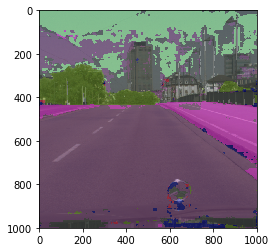

In [67]:
visualize_prediction(val_img, out)

In [134]:
output

<tf.Tensor 'output:0' shape=(?, ?, ?, 20) dtype=float32>

In [135]:
x

<tf.Tensor 'x:0' shape=<unknown> dtype=float32>

# Test on video frame (on orginal size : 1024x2048)

In [68]:
optimized_model = './output/frozen_FCN2_170816.pb'
graph = load_graph(optimized_model)

In [69]:
x = graph.get_tensor_by_name('x:0')
output = graph.get_tensor_by_name('div:0')

In [70]:
frame_path = '/data2/cityscapes_dataset/leftImg8bit_demoVideo/leftImg8bit/demoVideo/stuttgart_01/stuttgart_01_000000_004581_leftImg8bit.png'

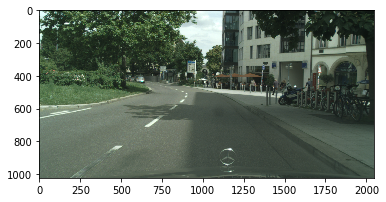

In [71]:
plot_image(image_path=frame_path)

In [72]:
img = misc.imread(frame_path).astype(np.float32)
img_arr = np.empty((1,img.shape[0],img.shape[1],img.shape[2]))
img_arr[0,:,:,:] = img

In [73]:
with tf.Session(graph=graph) as sess:
    %time result = sess.run(output, feed_dict={x: img_arr})

CPU times: user 6.16 s, sys: 1.2 s, total: 7.36 s
Wall time: 8.92 s


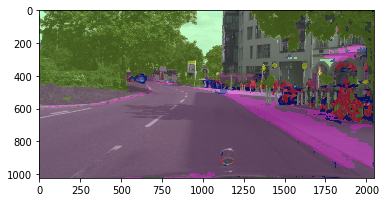

In [74]:
visualize_prediction(img_arr, result)

In [75]:
result.shape

(1, 1024, 2048, 20)